### This script will give you the distribution of displacement of the selected atom/ion cooresponding to the simulations you provided.

Trajectory 1: 1000 frames, 48297 atoms
Trajectory 2: 1000 frames, 37935 atoms
Selected atom indices: traj1 -> 3405, traj2 -> 3403
=== Metrics for Trajectory 1 ===
Max Distance: 1.1938
Range: 1.1938
Mean Distance: 0.7326
Std Dev: 0.2732
Area Under Curve: 73.1957
Entropy: 3.6708

=== Metrics for Trajectory 2 ===
Max Distance: 8.6296
Range: 8.6296
Mean Distance: 5.0753
Std Dev: 1.5888
Area Under Curve: 506.8302
Entropy: 3.5769


/var/folders/v3/gz_8y55s48ndvq0n3gvn3b0h0000gn/T/ipykernel_2985/1005248935.py:53: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  'Area Under Curve': simps(distances, times),


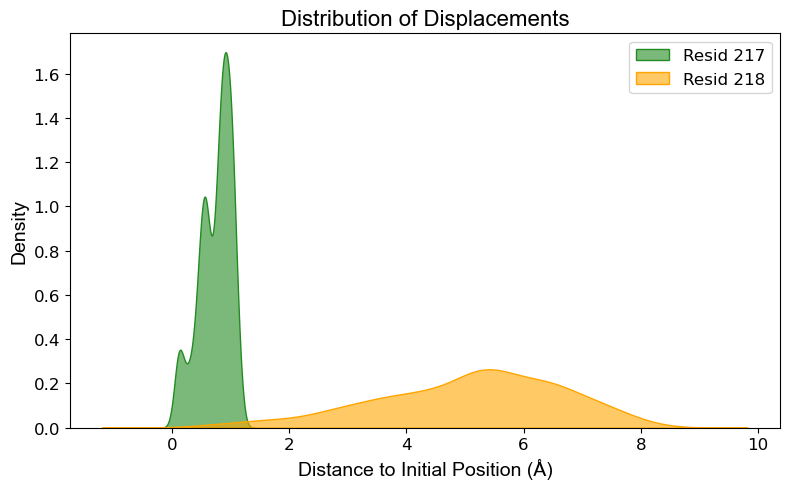

In [2]:
# Cell 1: Import necessary libraries
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import simps
from scipy.stats import entropy

# Cell 2: Load both trajectories
traj1 = md.load('chloron5_bound_every_100_bound.dcd', top='chloron5_bound.prmtop')
traj2 = md.load('chloron1_md_1-100_every100.dcd', top='chloron1.prmtop')

print(f"Trajectory 1: {traj1.n_frames} frames, {traj1.n_atoms} atoms")
print(f"Trajectory 2: {traj2.n_frames} frames, {traj2.n_atoms} atoms")

# Cell 3: Atom selection (now allows different resid numbers)
resid1 = 217  # Residue number for traj1
resid2 = 218  # Residue number for traj2
atom_name = 'Cl-'  # atom name must be same in both trajectories

def get_atom_index(traj, resid, atom_name):
    atoms = [atom.index for atom in traj.topology.atoms if atom.residue.resSeq == resid and atom.name == atom_name]
    if not atoms:
        raise ValueError(f"Atom {atom_name} at resid {resid} not found in trajectory.")
    return atoms[0]

atom_index1 = get_atom_index(traj1, resid1, atom_name)
atom_index2 = get_atom_index(traj2, resid2, atom_name)

print(f"Selected atom indices: traj1 -> {atom_index1}, traj2 -> {atom_index2}")

# Cell 4: Calculate distances to initial position
def compute_distance(traj, atom_index):
    initial = traj.xyz[0, atom_index, :]
    return np.linalg.norm(traj.xyz[:, atom_index, :] - initial, axis=1)

distances1 = compute_distance(traj1, atom_index1)
distances2 = compute_distance(traj2, atom_index2)

# Time arrays (in ns)
timestep_ns = 0.1  # adjust if your frame spacing is different
times1 = np.arange(traj1.n_frames) * timestep_ns
times2 = np.arange(traj2.n_frames) * timestep_ns

# Cell 5: Compute quantitative metrics
def get_metrics(distances, times):
    hist, _ = np.histogram(distances, bins=50, density=True)
    return {
        'Max Distance': np.max(distances),
        'Range': np.ptp(distances),
        'Mean Distance': np.mean(distances),
        'Std Dev': np.std(distances),
        'Area Under Curve': simps(distances, times),
        'Entropy': entropy(hist + 1e-10)
    }

metrics1 = get_metrics(distances1, times1)
metrics2 = get_metrics(distances2, times2)

print("=== Metrics for Trajectory 1 ===")
for k, v in metrics1.items():
    print(f"{k}: {v:.4f}")

print("\n=== Metrics for Trajectory 2 ===")
for k, v in metrics2.items():
    print(f"{k}: {v:.4f}")

# Cell 6: KDE distribution comparison
plt.figure(figsize=(8, 5))

sns.kdeplot(distances1, label=f'Resid {resid1}', fill=True, alpha=0.6, color='forestgreen')
sns.kdeplot(distances2, label=f'Resid {resid2}', fill=True, alpha=0.6, color='orange')

plt.xlabel('Distance to Initial Position (Å)', fontsize=14, fontname='Arial')
plt.ylabel('Density', fontsize=14, fontname='Arial')
plt.title('Distribution of Displacements', fontsize=16, fontname='Arial')
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('distribution-of-displacements.png', dpi=300)
plt.show()

##Optional section###

# Cell 7: 2D KDE Plot (Time vs Distance)

#fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

#sns.kdeplot(x=times1, y=distances1, fill=True, cmap='viridis', levels=100,
            #ax=axs[0], clip=((0, times1.max()), (distances1.min(), distances1.max())))
#axs[0].set_title(f'Traj1 - Resid {resid1}')
#axs[0].set_xlabel('Time (ns)')
#axs[0].set_ylabel('Distance (Å)')

#sns.kdeplot(x=times2, y=distances2, fill=True, cmap='magma', levels=100,
            #ax=axs[1], clip=((0, times2.max()), (distances2.min(), distances2.max())))
#axs[1].set_title(f'Traj2 - Resid {resid2}')
#axs[1].set_xlabel('Time (ns)')

#plt.suptitle('2D KDE: Distance to Initial Position over Time', fontsize=14)
#plt.tight_layout()
#plt.show()
